In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

base_dir = 'wec-intelligence-sig-2024-recruitment-task-cv/train_images'
train_dir = os.path.join(base_dir, 'train_images')

# Image parameters and Batch size
img_height, img_width = 250, 250
batch_size = 32

# Data generators with Augmentation details
# Validation split is kept as 0.2
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1.0 / 255.0,
    validation_split=0.2 
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', 
    subset='training',   
    seed=42              
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', 
    subset='validation', 
    seed=42          
)

Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


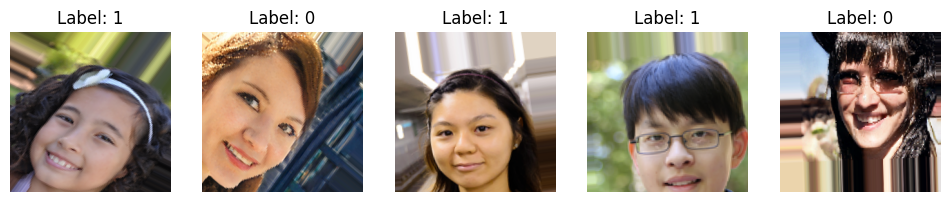

In [3]:
import matplotlib.pyplot as plt

images, labels = next(train_generator)

num_images = 5  

plt.figure(figsize=(12, 12))

for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')

plt.show()


In [3]:
from tensorflow.keras import initializers

# CNN Model Architecture
model = models.Sequential()

# Weight initialisation is set to he
# First tried without using any weight initialisation but it was randomly guessing and the val accuracy was hovering between 47 to 52.
# After it increased to 80 in one random training thought abt weight initialisations and tried he
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        kernel_initializer=initializers.HeNormal(), 
                        input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', 
                        kernel_initializer=initializers.HeNormal()))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', 
                        kernel_initializer=initializers.HeNormal()))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu', 
                       kernel_initializer=initializers.HeNormal()))
model.add(layers.Dense(1, activation='sigmoid'))

# Compilation
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 107648)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 107648)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      13,779,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,872,449 (52.92 MB)

 Trainable params: 13,872,449 (52.92 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Training
epochs = 20
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.9607 - loss: 0.1101 - val_accuracy: 0.9781 - val_loss: 0.0794
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.9711 - loss: 0.0927 - val_accuracy: 0.9844 - val_loss: 0.0605
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.9689 - loss: 0.0947 - val_accuracy: 0.9688 - val_loss: 0.1001
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.9394 - loss: 0.1415 - val_accuracy: 0.9688 - val_loss: 0.0730
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.9554 - loss: 0.1336 - val_accuracy: 0.9281 - val_loss: 0.2464
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.9285 - loss: 0.2170 - val_accuracy: 0.9375 - val_loss: 0.1684
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.9590 - loss: 0.1164 - val_accuracy: 0.9844 - val_loss: 0.0746
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.9755 - loss: 0.0711 - val_accuracy: 0.7906 - v

In [12]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

test_dir = 'wec-intelligence-sig-2024-recruitment-task-cv/test_images/test_images' 

# Image parameters
img_height, img_width = 250, 250
batch_size = 32

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img) 
    img_array = img_array / 255.0
    return img_array

results = {'ID': [], 'TARGET': []}

for filename in os.listdir(test_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_id = filename.split('_')[-1].split('.')[0] 
        image_path = os.path.join(test_dir, filename)

        img_array = load_and_preprocess_image(image_path)
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)
        predicted_class = 1 if prediction[0][0] > 0.5 else 0

        results['ID'].append(image_id)
        results['TARGET'].append(predicted_class)

results_df = pd.DataFrame(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━

In [13]:
#Since fake train directory is first while using flow from directory it is labeled as 0 and real is labeled as 1 so I swap it to get the correct labels.
#That can be seen in the random pics in train generator I have plotted
results_df['TARGET']=1-results_df['TARGET']

In [14]:
results_df['TARGET'].value_counts()

TARGET
1    219
0    181
Name: count, dtype: int64

In [15]:
results_df

,ID,TARGET
0,1,0
1,10,0
2,100,0
3,101,1
4,102,1
...,...,...
395,95,0
396,96,1
397,97,0
398,98,1


In [16]:
results_df.to_csv('output_tf2.csv', index=False)